In [1]:
import numpy  as np 
import pandas as pd 
import os
import cv2 
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

import keras
from keras.preprocessing import image
from keras.models import Model
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Input, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu, sigmoid
from keras.optimizers import Adam

# Global constants
IMG_DIM      = 256
BATCH_SIZE   = 32
CHANNEL_SIZE = 3
NUM_CLASSES  = 5

class_names = {"0":"No DR", "1":"Mild", "2":"Moderate", "3":"Severe", "4":"Proliferative DR"}


# data frame of current competition
df_2019 = pd.read_csv(f"../aptos2019/train.csv") 
df_2019.id_code = df_2019.id_code.apply(lambda x: x + ".png")
df_2019.id_code = df_2019.id_code.apply(lambda x: "modified_" + x) 
train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, shuffle=False)

# 2019 data frame 
df_2015 = pd.read_csv(f"../aptos2015/trainLabels.csv") 
df_2015.image   = df_2015.image.apply(lambda   x: x + ".jpeg")
df_2015["id_code"]   = df_2015.image
df_2015["diagnosis"] = df_2015.level
train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, shuffle=False)

# valid_2019['diagnosis'].value_counts().plot(kind='bar')
# plt.title('Samples Per Class')

Using TensorFlow backend.


5530


Text(0.5, 1.0, 'Samples Per Class')

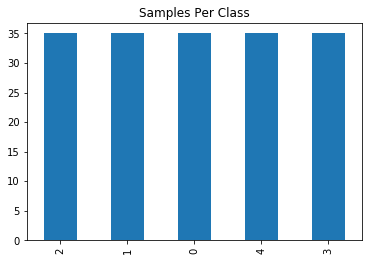

In [2]:
class_to_val = [[0.85, 0.1, 0.05, 0, 0],
                [0.1, 0.8, 0.1, 0, 0],
                [0, 0.15, 0.7, 0.15, 0],
                [0, 0, 0.1, 0.8, 0.1], 
                [0, 0, 0.05, 0.1, 0.85]]

def get_train_valid_df(year="2019", even_distrib=True):
    
    # shuffle data so each time different samples are dropped
    if (year == "2019"):
        train = train_2019.sample(frac=1)
        valid = valid_2019.sample(frac=1)
    elif (year == "2015"):
        train = train_2015.sample(frac=1)
        valid = valid_2015.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    for i in range(5):
        train[str(i)] = train.diagnosis.apply(lambda x: class_to_val[x][i])
        valid[str(i)] = valid.diagnosis.apply(lambda x: class_to_val[x][i])

    train.diagnosis = train.diagnosis.astype('str')
    valid.diagnosis = valid.diagnosis.astype('str')

    # drop classes 
    if even_distrib:
        min_train = min(train['diagnosis'].value_counts())
        min_valid = min(valid['diagnosis'].value_counts())

        for diagnosis in range(5):
            indexes_valid = valid[valid['diagnosis'] == str(diagnosis)].index
            indexes_train = train[train['diagnosis'] == str(diagnosis)].index
            
            frac_drop_train = indexes_train.size * (1 - min_train/indexes_train.size)
            frac_drop_valid = indexes_valid.size * (1 - min_valid/indexes_valid.size)
            
            train.drop(indexes_train[:int(frac_drop_train)], inplace=True)
            valid.drop(indexes_valid[:int(frac_drop_valid)], inplace=True)

    # shuffle it for even distribution later, and take a smaller batch if the train size is larger than 10000
    frac = 1
    print(train.size)
    if train.size > 10000:
        frac = 10000/train.size
    train = train.sample(frac=frac)
    valid = valid.sample(frac=frac)
    
    return train, valid

# plot example
_, df_to_plot = get_train_valid_df(year="2019")
df_to_plot['diagnosis'].value_counts().plot(kind='bar')
plt.title('Samples Per Class')

# df_to_plot.columns

5530


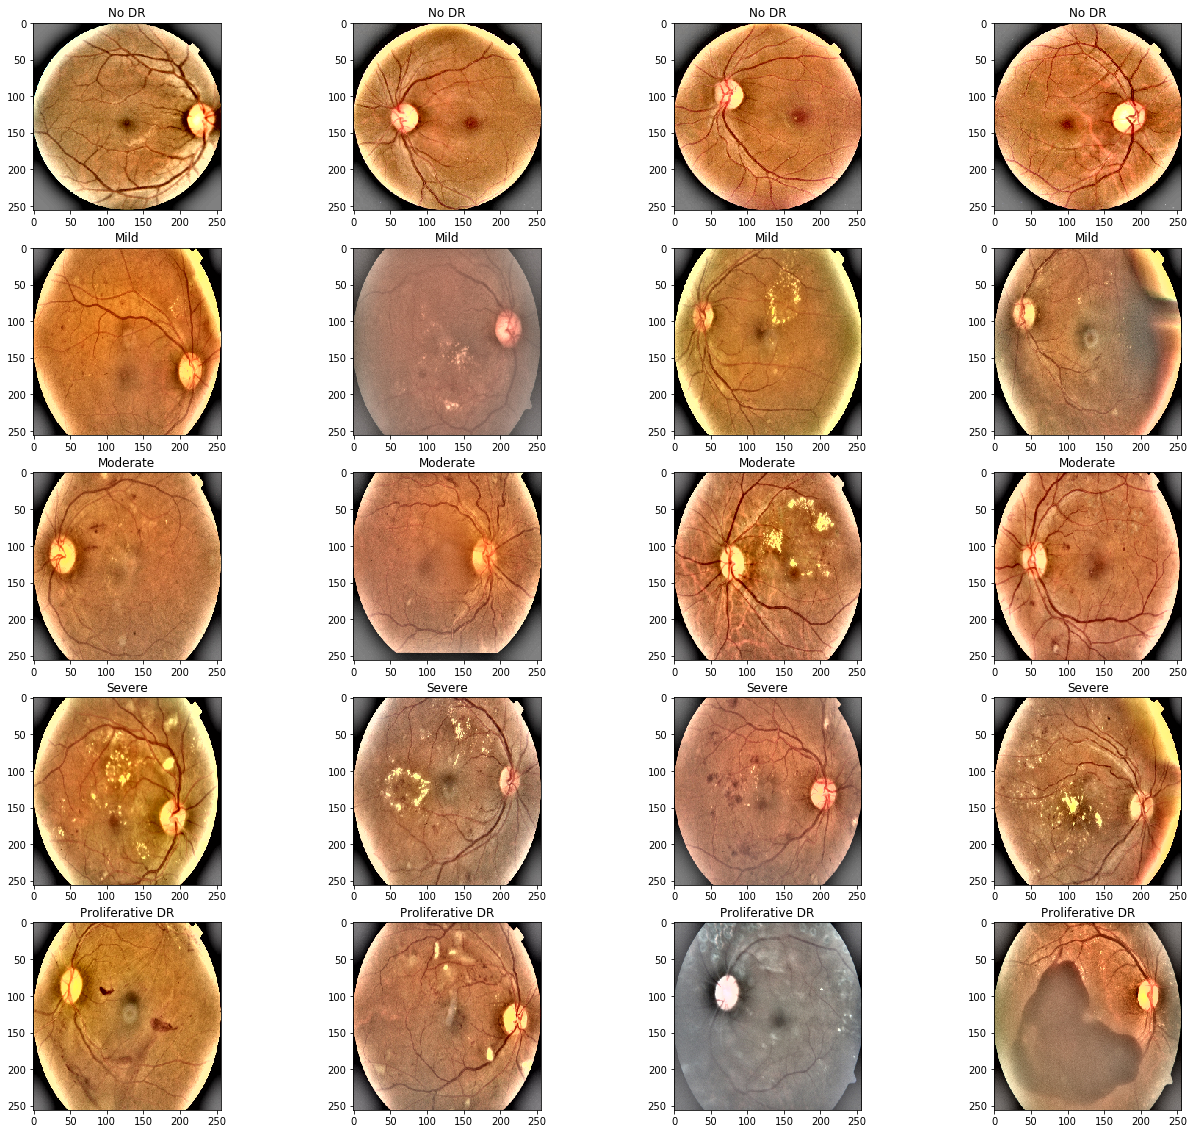

In [3]:
# display some data
df_example, _ = get_train_valid_df(year="2019")

# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(22,20))
for target_class in (df_example['diagnosis'].unique()):
    for i, (idx, row ) in enumerate(df_example.loc[df_example.diagnosis == target_class]
                                    .sample(4)
                                    .iterrows()):
        # open the file
        imagefile = f"../aptos2019/train_images/{row['id_code']}" 
        img = cv2.imread(imagefile)
        
        # original version
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = figure.add_subplot(5,4, int(target_class)*4+i+1)
        plt.imshow(rgb)
        ax.set_title(class_names[target_class])
        

In [19]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True, 
                                       vertical_flip=True,
                                       rotation_range=int(800*jitter),
                                       brightness_range=[1-jitter, 1+jitter],
                                       channel_shift_range=int(20*jitter),
                                       zoom_range=[(1-jitter)*ZOOM, (1+jitter)*ZOOM],
                                       fill_mode="reflect",
                                      )
    return datagen

def datagen_with_flow(datagen, dataframe, directory):
    return datagen.flow_from_dataframe(dataframe=dataframe, directory=directory,
                                       x_col="id_code", class_mode="raw",
                                       y_col=["0", "1", "2", "3", "4"],
                                       batch_size=BATCH_SIZE,
                                       target_size=(IMG_DIM, IMG_DIM),
                                       shuffle=False,
                                      )

def generator(jitter=0.1, year="2019"):
    
    train, valid = get_train_valid_df(year=year) 
    datagen = dataGenerator(jitter)
    
    train_gen = datagen_with_flow(datagen, train, f"../aptos{year}/train_images/")
    valid_gen = datagen_with_flow(datagen, valid, f"../aptos{year}/train_images/")
    
    return train_gen, valid_gen

gc.collect()


0

5530
Found 790 validated image filenames.
Found 175 validated image filenames.


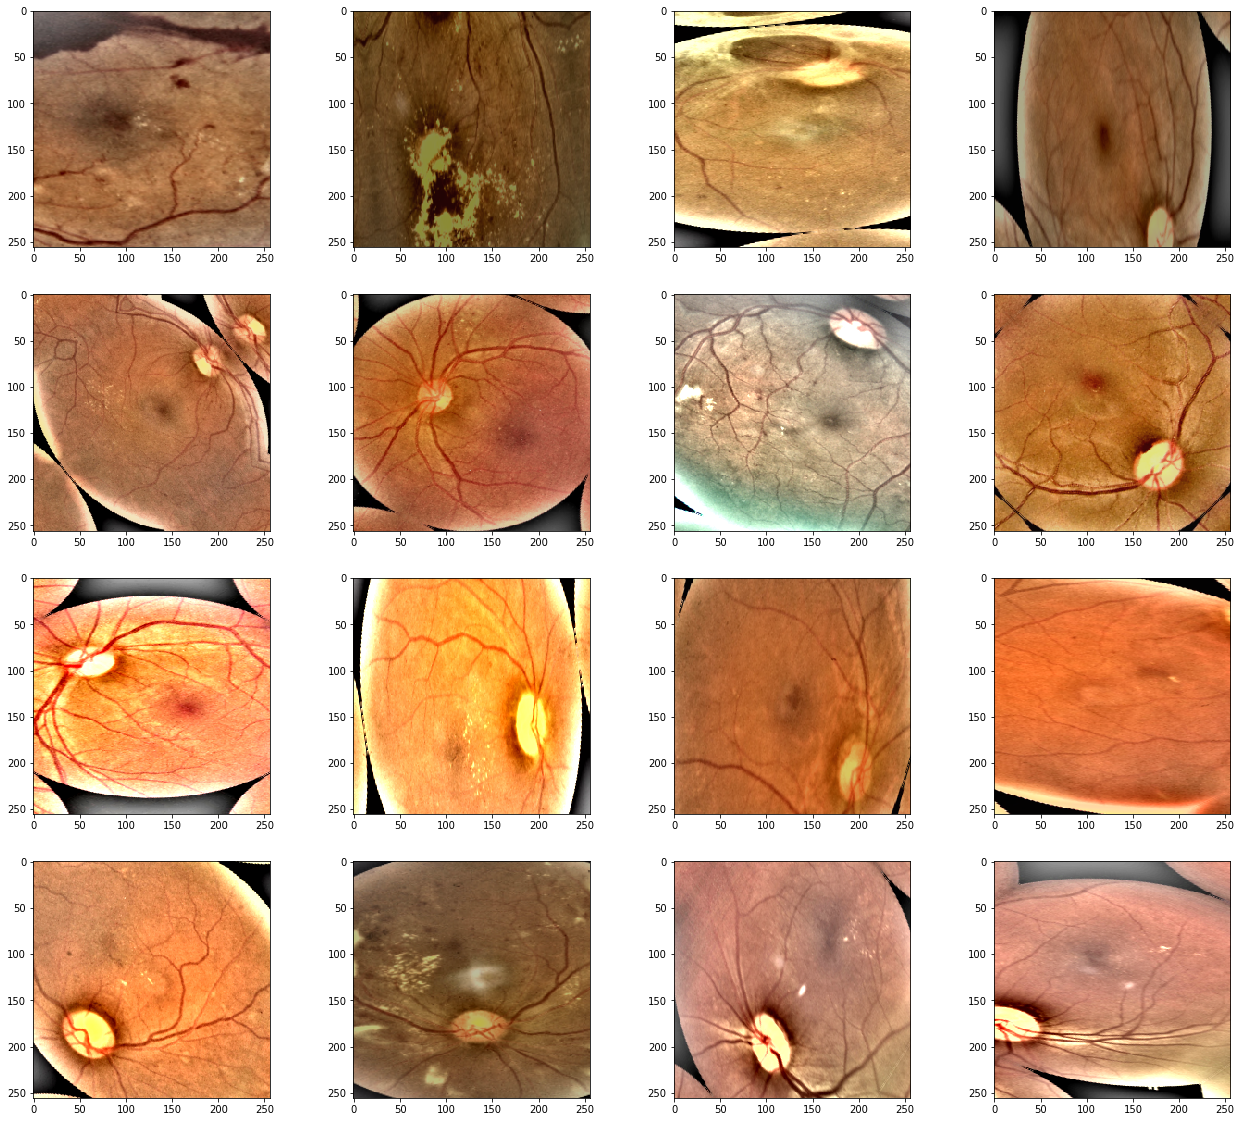

In [20]:
train_sample_gen, valid_sample_gen = generator(jitter=0.5)

# Display some data generation
figure=plt.figure(figsize=(22,20))
for batch in valid_sample_gen:
    for j in range(16):
        ax = figure.add_subplot(4,4, j+1)
        batch[0][j] = np.clip(batch[0][j], 0, 1)
        plt.imshow(batch[0][j])
    break

In [9]:
class Metrics(Callback):
    def __init__(self, generator):
        self.generator = generator
        
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        numBatches = 5
        val_kappa  = 0
        for x, y in self.generator:
            predictions = model.predict(x)
            y_pred = np.argmax(predictions, axis=1)
            y_val  = np.argmax(y, axis=1)
            val_kappa += cohen_kappa_score(y_val, y_pred, weights='quadratic')/5
            
            numBatches -= 1
            if numBatches == 0:
                break
            
#         print(y_val[:5], predictions[:5])

            
        self.val_kappas.append(val_kappa)
        print(f"val_kappa: {val_kappa:.4f}")

        if val_kappa == max(self.val_kappas) and val_kappa > 0.8:
            print("Max of this run, saving model.")
            model.save(f"dense-regression-2-{val_kappa:.2f}.h5")


In [10]:
def create_model(img_dim, CHANNELS, n_class):
    
    input_tensor = Input(shape=(img_dim, img_dim, CHANNELS))
    base_model   = DenseNet121(weights=None, include_top=False, input_tensor=input_tensor)
#     base_model.load_weights('../DenseNet-BC-121-32-no-top.h5')
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(512, activation=relu)(x)
    x = Dropout(0.15)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class, activation='sigmoid', name="Output_Layer")(x)
    model = Model(input_tensor, output_layer)
    
    return model

model = create_model(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)
model.load_weights("dense-regression-0.83.h5") 



W0812 03:17:14.181658 140337510606592 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 03:17:14.199795 140337510606592 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 03:17:14.335718 140337510606592 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 03:17:14.358036 140337510606592 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The n

In [21]:
 for jitter in [0.5, 0.2, 0.1, 0.05]:
    
    model.compile(optimizer=Adam(lr=0.00005), loss=keras.losses.mean_squared_error,  metrics=['accuracy'])
    
    for year in ["2015", "2015", "2015", "2019"]:

        # these need to be global for the kappa callback
        train_generator, valid_generator = generator(jitter=0.1, year=year)

        # Call backs during training            
        kappa_callbacks = Metrics(valid_generator)
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
        reduce_lr  = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, 
                                       min_lr=1e-7, mode='auto', verbose=1)

        # train the model for 12 epochs
        history = model.fit_generator(generator=train_generator,
                                      steps_per_epoch=train_generator.n  // train_generator.batch_size,
                                      validation_data=valid_generator,
                                      validation_steps=valid_generator.n // valid_generator.batch_size,
                                      epochs=6,
                                      callbacks=[early_stop, reduce_lr, kappa_callbacks],
                                      verbose=1
                                     )
    
    gc.collect()

25074
Found 1111 validated image filenames.
Found 302 validated image filenames.
Epoch 1/6
34/34 [==============================] - 90s 3s/step - loss: 0.0726 - acc: 0.5230 - val_loss: 0.0774 - val_acc: 0.4965
val_kappa: 0.7088
Epoch 2/6
34/34 [==============================] - 40s 1s/step - loss: 0.0694 - acc: 0.5326 - val_loss: 0.0862 - val_acc: 0.5000
val_kappa: 0.7244
Epoch 3/6
34/34 [==============================] - 40s 1s/step - loss: 0.0702 - acc: 0.5363 - val_loss: 0.1069 - val_acc: 0.4778

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
val_kappa: 0.7146
Epoch 4/6
34/34 [==============================] - 40s 1s/step - loss: 0.0669 - acc: 0.5379 - val_loss: 0.0942 - val_acc: 0.4889
val_kappa: 0.6423
Epoch 00004: early stopping
25074
Found 1111 validated image filenames.
Found 302 validated image filenames.
Epoch 1/6
34/34 [==============================] - 45s 1s/step - loss: 0.0743 - acc: 0.4890 - val_loss: 0.0874 - val_acc: 0.4514
val_kappa: 0

34/34 [==============================] - 41s 1s/step - loss: 0.0626 - acc: 0.5705 - val_loss: 0.0644 - val_acc: 0.5347
val_kappa: 0.7578
Epoch 6/6
34/34 [==============================] - 41s 1s/step - loss: 0.0628 - acc: 0.5738 - val_loss: 0.0697 - val_acc: 0.4741

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
val_kappa: 0.6651
25074
Found 1111 validated image filenames.
Found 302 validated image filenames.
Epoch 1/6
34/34 [==============================] - 44s 1s/step - loss: 0.0704 - acc: 0.5211 - val_loss: 0.0652 - val_acc: 0.5243
val_kappa: 0.6705
Epoch 2/6
34/34 [==============================] - 41s 1s/step - loss: 0.0688 - acc: 0.5288 - val_loss: 0.0677 - val_acc: 0.5397
val_kappa: 0.7445
Epoch 3/6
34/34 [==============================] - 41s 1s/step - loss: 0.0694 - acc: 0.5142 - val_loss: 0.0649 - val_acc: 0.5382

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-07.
val_kappa: 0.7389
Epoch 4/6
34/34 [===============